In [1]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from IPython.display import display, Math
import random

In [2]:
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
df = x[:,2]

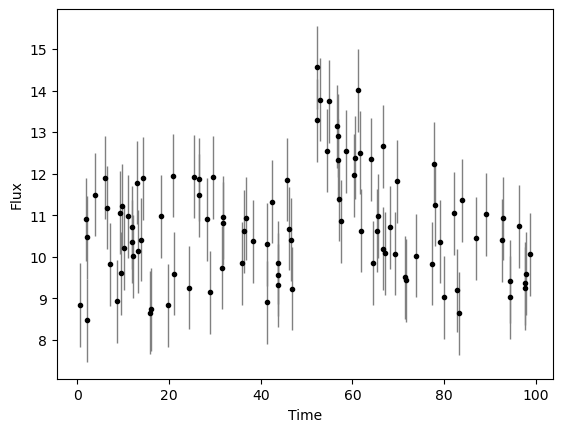

In [3]:
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [4]:
def model(time, theta):
    A, b, t0, alpha = theta
    return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))

## Fit by eye

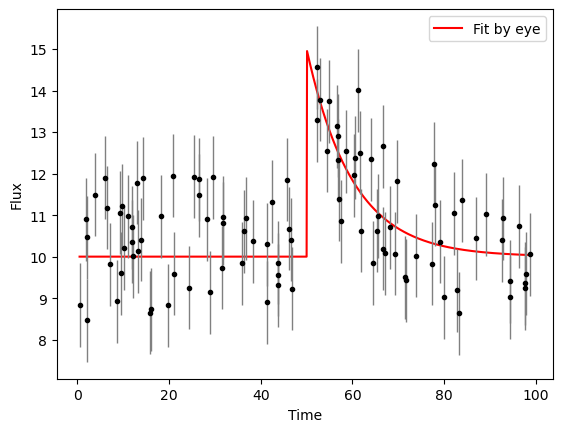

In [5]:
A_eye = 5
b_eye = 10
t0_eye = 50
alpha_eye = 0.1
theta_eye = [A_eye, b_eye, t0_eye, alpha_eye]

time_grid = np.linspace(time.min(), time.max(), 1000)

plt.plot(time_grid, model(time_grid, theta_eye), color = 'red', label = 'Fit by eye')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

## MCMC using emcee

In [6]:
t0min, t0max = 0, 100
Amin, Amax = 0, 50
bmin, bmax = 0, 50
alphamin, alphamax = np.exp(-5), np.exp(5)

In [7]:
def Logprior(theta):
    A, b, t0, alpha = theta 
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf

def LogLikelihood(theta, df, flux):
    y_fit = model(time, theta)
    return -0.5 * np.sum((flux-y_fit)**2 / df**2) 

def LogPosterior(theta, df, flux):
    return LogLikelihood(theta, df, flux) + Logprior(theta)

In [8]:
ndim = 4 
nwalkers = 10  
burn = 10000  
nsteps = 100000  

np.random.seed(42)
starting_guesses = theta_eye + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[df, flux])
sampler.run_mcmc(starting_guesses, nsteps)

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

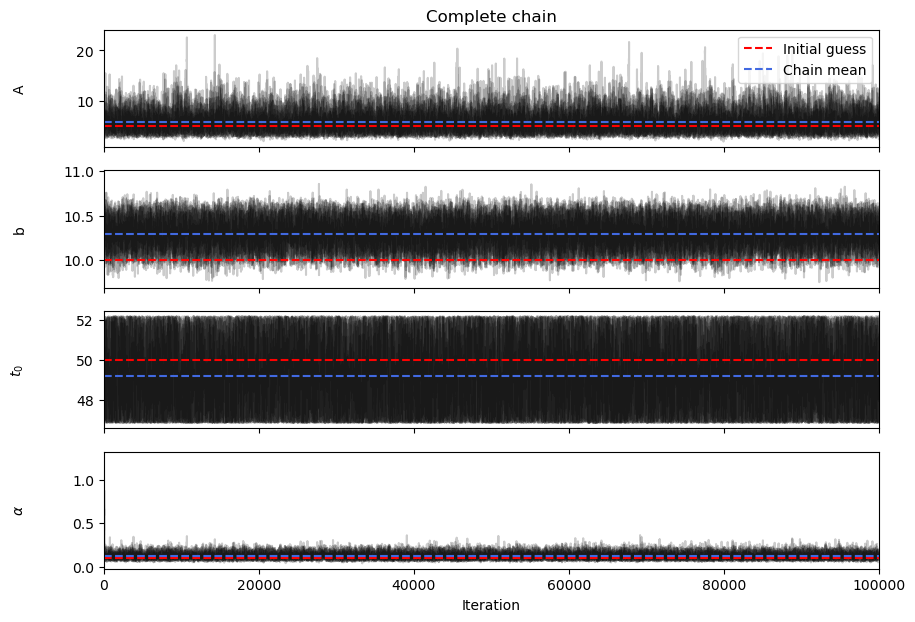

In [9]:
samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ['A', 'b', r'$t_0$', r'$\alpha$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color = 'black', alpha=0.2)
    ax.axhline(theta_eye[i], color = 'red', ls = '--', label = 'Initial guess')
    ax.axhline(np.mean(samples[:, :, i]), color = 'royalblue', ls = '--', label='Chain mean')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('Iteration')
axes[0].legend()
axes[0].set_title('Complete chain')
plt.show()

In [10]:
tau = sampler.get_autocorr_time()
thin = tau.astype(int) + 1
print('Autocorrelation times:\n%f, %f, %f, %f' %(tau[0], tau[1], tau[2], tau[3]))

Autocorrelation times:
89.990727, 70.171576, 98.931337, 73.267074


In [11]:
burned_trace = sampler.get_chain(discard = 10*max(thin), thin=max(thin), flat=True)

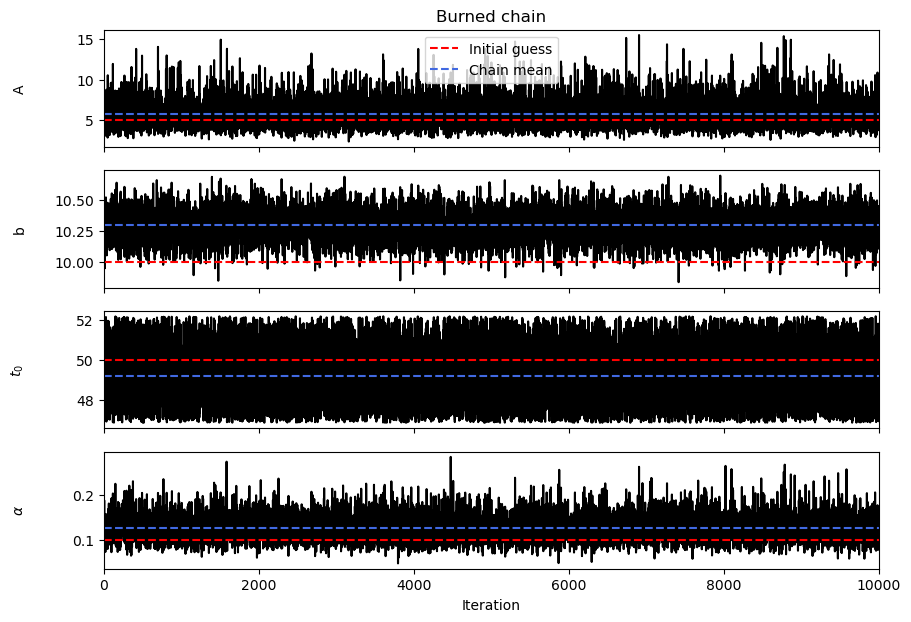

In [20]:
fig1, axes1 = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes1[i].plot(burned_trace[:,i], color = 'black')
    axes1[i].axhline(theta_eye[i], color = 'red', ls = '--', label = 'Initial guess')
    axes1[i].axhline(np.mean(burned_trace[:, i]), color = 'royalblue', ls = '--', label='Chain mean')
    axes1[i].set_xlim(0, len(burned_trace))
    axes1[i].set_ylabel(labels[i])
    axes1[i].yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel('Iteration')
axes1[0].legend()
axes1[0].set_title('Burned chain')
plt.show()

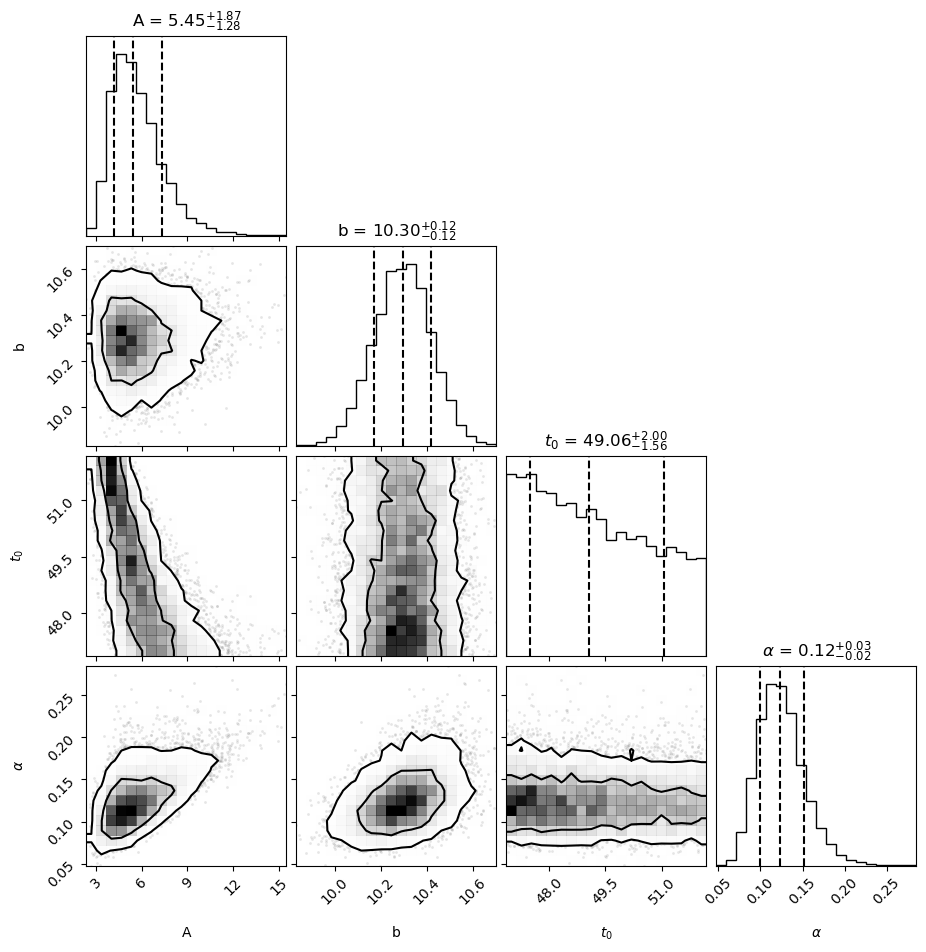

In [13]:
fig = corner.corner(burned_trace, labels=labels, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84]);

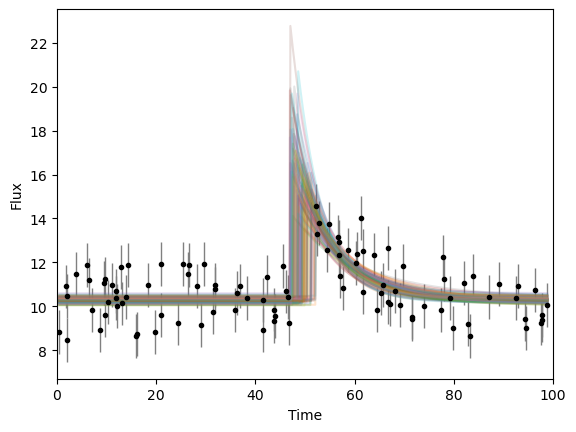

In [14]:
new_sample = np.array(random.sample(burned_trace.tolist(), 100))

plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
[plt.plot(time_grid, model(time_grid, param), alpha=0.2) for param in new_sample];
plt.xlim(0, len(new_sample))
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()

In [15]:
median = []
q = []
perc = []
for i in range(ndim):
    median.append(np.median(burned_trace[:, i]))
    perc.append(np.percentile(burned_trace[:, i], [5, 50, 95]))
    q.append(np.diff(perc[i]))
    name = [r'$A$', r'$b$', r'$\alpha$', r'$t_0$']
    txt = name[i]+r"$ = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
    txt = txt.format(median[i], q[i][0], q[i][1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

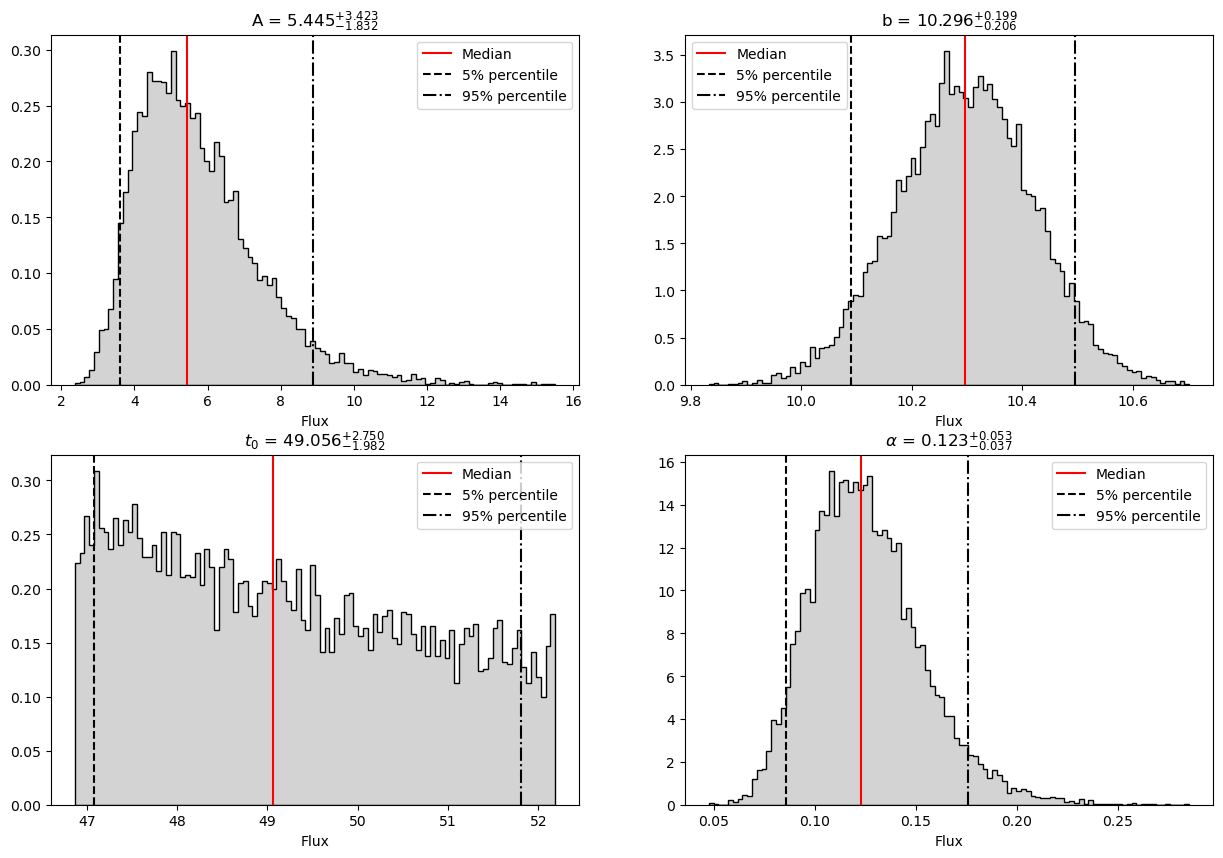

In [19]:
fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10))

k = 0
for i in range(2):
    for j in range (2):
        axs2[i, j].hist(burned_trace[:, k], bins = 100, density = True, ec='black', fc='lightgrey', histtype='stepfilled')
        axs2[i, j].set_xlabel('Flux')
        axs2[i, j].set_title(r'%s = $%0.3f^{+%0.3f}_{-%0.3f}$' %(labels[k], median[k], q[k][1], q[k][0]))
        axs2[i, j].axvline(median[k], color = 'red', label = 'Median')
        axs2[i, j].axvline(perc[k][0], color = 'black', ls = '--', label = '5% percentile')
        axs2[i, j].axvline(perc[k][2], color = 'black', ls = '-.', label = '95% percentile')
        axs2[i, j].legend()
        k += 1

plt.show()

In [17]:
log_probabilities = sampler.get_log_prob(discard = 10*max(thin), thin=max(thin), flat=True)
max_posterior = burned_trace[np.argmax(log_probabilities)]
print('Parameters that maximize the posterior: ', max_posterior)

Parameters that maximize the posterior:  [ 4.04182628 10.27550511 51.49570905  0.11257333]


## Ha senso fittare i dati con questi parametri?

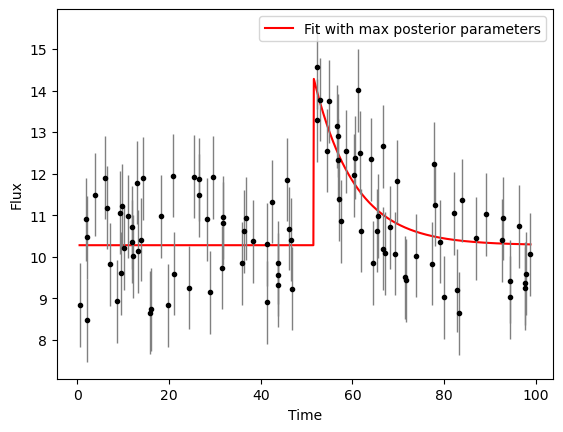

In [18]:
plt.plot(time_grid, model(time_grid, max_posterior), color = 'red', label = 'Fit with max posterior parameters')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()